In [20]:
import numpy as np
import pandas as pd

from scipy.stats import mannwhitneyu, chi2_contingency, ttest_ind 
from scipy.stats import anderson, anderson_ksamp
from scipy.stats import chi2, t, sem
import matplotlib.pyplot as plt

Загрузим таблицу application_train.csv:

In [21]:
PATH_TO_TRAIN = '/home/user/Downloads/hw/SHIFT/src/hw_5/application_train.csv'

df = pd.read_csv(PATH_TO_TRAIN)

df['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

Разделим признаки на категориальные и числовые. \
Для проверки значимости к категориальным признакам будем применять критерий хи-квадрат, к числовым - t-test (для нормально распределённых) или критерий Манна-Уитни (для ненормально распределённых).

In [22]:
cat_cols = [c for c in df.columns if df[c].dtype in ['object']]
num_cols = df.columns.drop(cat_cols).drop(['TARGET', 'SK_ID_CURR'])
df = df.dropna()
df = df.fillna(0)
len(df.columns), len(cat_cols), len(num_cols)

(122, 16, 104)

In [23]:
num_cols_norm = []
num_cols_not_norm = []
for col in num_cols:
    stat, crit_val, sign_level = anderson(df[df['TARGET']==1][col], 'norm')
    if stat < crit_val[4]:
        num_cols_norm.append(col)
    else:
        num_cols_not_norm.append(col)

len(num_cols), len(num_cols_norm), len(num_cols_not_norm)


/home/user/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:1948: RuntimeWarning: invalid value encountered in divide
  w = (y - xbar) / s


(104, 0, 104)

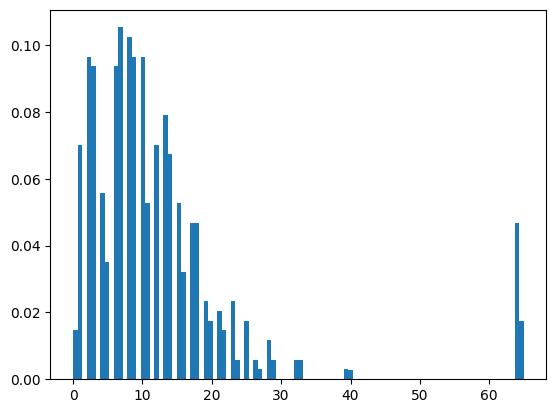

In [24]:
plt.hist(df[df['TARGET']==1][num_cols_not_norm[10]], density='norm', bins=100)
plt.show()

Определим статистически значимые категориальные признаки:

In [25]:
good_num = []
for col in num_cols_not_norm:
    _, p_mw = mannwhitneyu(df[df['TARGET']==0][col], df[df['TARGET']==1][col])
    if p_mw < 0.05:
        good_num.append(col)
len(good_num)

47

In [26]:
good_cat = []
def hi(col):
    cross_tab = pd.concat([
        pd.crosstab(df[col], df['TARGET'], margins=False), 
        df.groupby(col)['TARGET'].agg(['count', 'mean']).round(4)
    ], axis=1).rename(columns={0: f"label=0", 1: f"label=1", "mean": 'probability_of_default'})
    
    cross_tab['probability_of_default'] = np.round(cross_tab['probability_of_default'] * 100, 2)

    chi2_stat, p, dof, expected = chi2_contingency(cross_tab.values)

    prob = 0.95
    critical = chi2.ppf(prob, dof)
    if abs(chi2_stat) >= critical:
        good_cat.append(col)

In [27]:
for col in cat_cols:
    hi(col)
len(good_cat)

13

В результате осталось 60 признаков: 13 категориальных и 47 числовых.

In [28]:
good_df1 = df[['SK_ID_CURR','TARGET'] + good_num + good_cat]
good_df1.to_csv('good_df1.csv')
good_df1

SK_ID_CURR  TARGET  AMT_INCOME_TOTAL  DAYS_BIRTH  DAYS_EMPLOYED  \
71          100083       0          103500.0      -15406           -892   
124         100145       0          202500.0      -16282          -4375   
152         100179       0          202500.0      -11375          -2311   
161         100190       0          162000.0      -13972          -4472   
255         100295       1          225000.0      -11356           -602   
...            ...     ...               ...         ...            ...   
307358      456083       0          112500.0      -15006          -1105   
307359      456084       0           99000.0      -14007          -2021   
307407      456140       1          261000.0      -11407          -1641   
307456      456195       0           94500.0      -20246          -5452   
307482      456226       0          225000.0      -14106           -226   

        DAYS_ID_PUBLISH  OWN_CAR_AGE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
71                -4176         22.0              2.0                     2   
124               -1494          8.0              2.0                     2   
152               -2009          4.0              2.0                     2   
161               -4529          3.0              2.0                     2   
255               -3224          9.0              2.0                     1   
...                 ...          ...              ...                   ...   
307358            -2465          9.0              4.0                     2   
307359            -1177         14.0              2.0                     3   
307407            -2923          4.0              3.0                     2   
307456            -3784          5.0              2.0                     2   
307482             -933         11.0              2.0                     2   

        REGION_RATING_CLIENT_W_CITY  ...      NAME_INCOME_TYPE  \
71                                2  ...               Working   
124                               2  ...               Working   
152                               2  ...  Commercial associate   
161                               2  ...  Commercial associate   
255                               1  ...  Commercial associate   
...                             ...  ...                   ...   
307358                            2  ...  Commercial associate   
307359                            3  ...               Working   
307407                            2  ...  Commercial associate   
307456                            2  ...               Working   
307482                            2  ...  Commercial associate   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
71      Secondary / secondary special               Married   
124     Secondary / secondary special             Separated   
152                  Higher education               Married   
161                  Higher education               Married   
255     Secondary / secondary special  Single / not married   
...                               ...                   ...   
307358  Secondary / secondary special               Married   
307359  Secondary / secondary special             Separated   
307407               Higher education               Married   
307456  Secondary / secondary special               Married   
307482  Secondary / secondary special               Married   

        NAME_HOUSING_TYPE  OCCUPATION_TYPE       ORGANIZATION_TYPE  \
71      House / apartment         Laborers  Business Entity Type 3   
124     House / apartment         Laborers           Self-employed   
152     House / apartment         Managers           Trade: type 7   
161     House / apartment         Laborers              Government   
255     House / apartment         Laborers  Business Entity Type 3   
...                   ...              ...                     ...   
307358  House / apartment   Security staff              Government   
307359  House / apartment   Security staff      

## Bootstrap

Возьмём функции из лекции

In [29]:
def confidence_interval(
    s1, s2, n, p
):
    '''
    Вычисление доверительного интервала
    
    s1 - распределение средних для 1 группы
    s2 - распределение средних для 2 группы
    n - объем смоделируемой выборки
    p = 1-alpha - 95% 
    
    return:
    (s1[l_indx], s1[u_indx]), (s2[l_indx], s2[u_indx]) - доверительные интервалы для 2х групп
    '''
    u_pval = (1 + p) / 2
    l_pval = (1 - u_pval)
    l_indx = int(np.floor(n*l_pval))
    u_indx = int(np.floor(n*u_pval))
    return (s1[l_indx], s1[u_indx]), (s2[l_indx], s2[u_indx])

def bootstrap(
    data1, 
    data2, 
    n=10000, 
    func=np.mean, 
    subtr=np.subtract, 
    alpha=0.05
):
    '''
    Бутстрап средних значений для двух групп
    
    data1 - выборка 1 группы
    data2 - выборка 2 группы
    n=10000 - сколько раз моделировать
    func=np.mean - функция отвыборки, например, среднее
    subtr=np.subtract, 
    alpha=0.05 - 95% доверительный интервал
    
    return:
    ci_diff - доверительный интервал разницы средних для двух групп
    s1 - распределение средних для 1 группы
    s2 - распределение средних для 2 группы
    confidence_interval(s1, s2, n, 1 - alpha) - доверительные интервалы для двух групп
    '''
    s1, s2 = [], []
    s1_size = len(data1)
    s2_size = len(data2)
    
    
    for i in range(n):
        itersample1 = np.random.choice(data1, size=s1_size, replace=True)
        s1.append(func(itersample1))
        itersample2 = np.random.choice(data2, size=s2_size, replace=True)
        s2.append(func(itersample2))
    s1.sort()
    s2.sort()
    
    #доверительный интервал разницы
    bootdiff = subtr(s2, s1)
    bootdiff.sort()

    ci_diff = (np.round(bootdiff[np.round(n*alpha/2).astype(int)], 3), 
               np.round(bootdiff[np.round(n*(1-alpha/2)).astype(int)], 3))  
    
    return ci_diff, s1, s2, confidence_interval(s1, s2, n, 1 - alpha)

def plot_bootstraping_mean(
    data, 
    y, 
    feat_name=None,
    val=[0, 1]
):
    '''
    Бутстрап средних значений для любого признака
    
    data - датафрейм с данными
    y - таргет
    feat_name - название признака, строка
    
    return:
    cidiff - доверительный интервал разницы в средних значениях для двух групп
    '''
    data1 = data[(y==val[0])][feat_name]
    data2 = data[(y==val[1])][feat_name]
    # s1_mean_init = np.mean(data1)
    # s2_mean_init = np.mean(data2)
      
    cidiff, s1, s2, ci = bootstrap(data1, data2)
    
    # plt.hist(x=s1, density='uniform',  label=f'target={val[0]}', bins='auto', alpha=0.8, color='darkorange' )
    # plt.hist(x=s2, density='uniform', label=f'target={val[1]}', bins='auto', alpha=0.6, color='royalblue')
    # plt.legend()
    # plt.axvline(x=s1_mean_init, color='darkorange')
    # plt.axvline(x=s2_mean_init, color='royalblue')
    # plt.axvline(x=ci[0][0], color='orange', linestyle='--')
    # plt.axvline(x=ci[0][1], color='orange', linestyle='--')
    # plt.axvline(x=ci[1][0], color='blue', linestyle='--')
    # plt.axvline(x=ci[1][1], color='blue', linestyle='--')
    # plt.show()
    
    return cidiff

def verdict(ci_diff):
    cidiff_min=0.001 #,близкое к 0
    ci_diff_abs = [abs(ele) for ele in ci_diff]
    if (min(ci_diff) <= cidiff_min <= max(ci_diff)):
        # print(ci_diff,'Различия в средних статистически незначимы.')
        return 0
    elif (cidiff_min >= max(ci_diff_abs) >= 0) or (cidiff_min >= min(ci_diff_abs) >= 0):
        # print(ci_diff,'Различия в средних статистически незначимы.')
        return 0
    else:
        # print(ci_diff,'Различия в средних статистически значимы.')
        return 1

### Посмотрим результат на примере одной колонки

In [30]:
n = 10000
col =  'AMT_INCOME_TOTAL'
mean_dist = []
for i in range(n):
    itersample = np.random.choice(df[(df['TARGET']==1)][col], 
                                  size=df[(df['TARGET']==1)].shape[0],
                                  replace=True)
    mean_dist.append(np.mean(itersample))

In [31]:
mean_dist_s = []
for i in range(n):
    itersample = df[(df['TARGET']==1)][col].sample(
        df[(df['TARGET']==1)].shape[0],
        replace = True # параметр возвращения
    ).values
    mean_dist_s.append(np.mean(itersample))

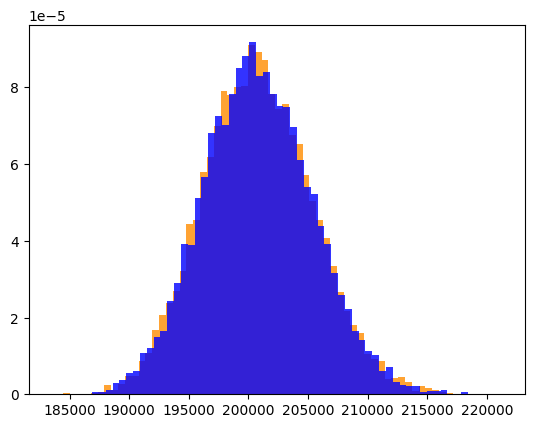

In [32]:
plt.hist(x=mean_dist, density='uniform', bins='auto', alpha=0.8, color='darkorange' )
plt.hist(x=mean_dist_s, density='uniform', bins='auto', alpha=0.8, color='blue' )
plt.show()

In [33]:
p = 0.95
pd.Series(mean_dist).quantile([(1 + p) / 2, 1 - (1 + p) / 2])

0.975    210132.662809
0.025    192221.213142
dtype: float64

In [34]:
cidiff = plot_bootstraping_mean(df, df['TARGET'], feat_name=col)

In [35]:
verdict(cidiff)

1

### Применим ко всем числовым столбцам

In [36]:
def find_important_features(df):
    important_features = []
    for col in num_cols:
        data1 = df[(df['TARGET']==0)][col]
        data2 = df[(df['TARGET']==1)][col]
        cidiff, s1, s2, ci = bootstrap(data1, data2)
        if verdict(cidiff) == 1:
            important_features.append(col)
    return important_features


In [37]:
important_features = find_important_features(df)

In [38]:
len(df[important_features].columns)

50

Получилось 50 статически значимых числовых признака.

In [39]:
good_df2 = df[['SK_ID_CURR','TARGET'] + important_features + good_cat]
good_df2.to_csv('good_df2.csv')
good_df2

SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
71          100083       0             0          103500.0    573628.5   
124         100145       0             1          202500.0    260725.5   
152         100179       0             0          202500.0    675000.0   
161         100190       0             0          162000.0    263686.5   
255         100295       1             1          225000.0   1019205.0   
...            ...     ...           ...               ...         ...   
307358      456083       0             2          112500.0    361462.5   
307359      456084       0             1           99000.0    675000.0   
307407      456140       1             1          261000.0    711454.5   
307456      456195       0             0           94500.0    270000.0   
307482      456226       0             0          225000.0    500566.5   

        AMT_GOODS_PRICE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_ID_PUBLISH  \
71             463500.0      -15406           -892            -4176   
124            198000.0      -16282          -4375            -1494   
152            675000.0      -11375          -2311            -2009   
161            238500.0      -13972          -4472            -4529   
255            774000.0      -11356           -602            -3224   
...                 ...         ...            ...              ...   
307358         274500.0      -15006          -1105            -2465   
307359         675000.0      -14007          -2021            -1177   
307407         643500.0      -11407          -1641            -2923   
307456         270000.0      -20246          -5452            -3784   
307482         472500.0      -14106           -226             -933   

        OWN_CAR_AGE  ...      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
71             22.0  ...               Working  Secondary / secondary special   
124             8.0  ...               Working  Secondary / secondary special   
152             4.0  ...  Commercial associate               Higher education   
161             3.0  ...  Commercial associate               Higher education   
255             9.0  ...  Commercial associate  Secondary / secondary special   
...             ...  ...                   ...                            ...   
307358          9.0  ...  Commercial associate  Secondary / secondary special   
307359         14.0  ...               Working  Secondary / secondary special   
307407          4.0  ...  Commercial associate               Higher education   
307456          5.0  ...               Working  Secondary / secondary special   
307482         11.0  ...  Commercial associate  Secondary / secondary special   

          NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  OCCUPATION_TYPE  \
71                   Married  House / apartment         Laborers   
124                Separated  House / apartment         Laborers   
152                  Married  House / apartment         Managers   
161                  Married  House / apartment         Laborers   
255     Single / not married  House / apartment         Laborers   
...                      ...                ...              ...   
307358               Married  House / apartment   Security staff   
307359             Separated  House / apartment   Security staff   
307407               Married  House / apartment      Sales staff   
307456               Married  House / apartment   Cleaning staff   
307482               Married  House / apartment         Managers   

             ORGANIZATION_TYPE     FONDKAPREMONT_MODE  HOUSETYPE_MODE  \
71      Business Entity Type 3       reg oper account  block of flats   
124              Self-employed  reg oper spec account  block of flats   
152              Trade: type 7       reg oper account  block of flats   
161                 Government       reg oper account  block of flats   
255     Business Entity Type 3       reg oper account  block of flats   
...                        ...        